# Score Based Generative Models Using Stochastic Differential Equations

Incorporating the same UNET from DDPM via the VP SDE framework.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import os
from typing import Dict
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Architecture

In [3]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class GaussianFourierEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        assert dim % 2 == 0, "Dimension must be even for equal number of sin and cos"
        self.W = nn.Parameter(torch.randn(dim//2), requires_grad=False)
        
    def forward(self, t):
        t_proj = t[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(t_proj), torch.cos(t_proj)], dim=-1)


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x)
        h += self.temb_proj(temb)[:, :, None, None]
        h = self.block2(h)

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = GaussianFourierEmbedding(tdim)

        self.head = nn.Conv2d(1, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=True),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=(i in attn)))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):
        # Timestep embedding
        temb = self.time_embedding(t)
        # Downsampling
        h = self.head(x)
        hs = [h]
        for layer in self.downblocks:
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks:
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks:
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h

Making sure the architecture works with regular DDPM, it should but just making sure! Training DDPM the same way, but sampling according to the score.
The following method is like a mix between the method offered in DDPM and the method offered in Score-Based Generative Modeling Through SDEs. Below we can see an implementation that is not a mix whatsoever.

## Approach viewing the DDPM network as a score network 

In [4]:
def transform(t, T):
    assert all(t >= 0) and all(t <= 1), "t should be between 0 and 1 only!"
    return (t * T).to(torch.int)

In [15]:
class DiffusionLoss(nn.Module):
    def __init__(self, T, model, beta_0, beta_1):
        super().__init__()
        self.T = T  # Number of distinct timesteps (not counting 0).
        self.model = model
        self.register_buffer('beta', torch.linspace(beta_0, beta_1, T))
        a = 1 - self.beta
        alpha = torch.cumprod(a, 0)
        self.register_buffer('sqrt_alpha', alpha.sqrt())
        self.register_buffer('sqrt_1m_alpha', (1 - alpha).sqrt())

    def forward(self, train_x):
        B, C, H, W = train_x.shape
        t = (torch.randint(self.T, (B,)) / self.T).to(device)
        noise = torch.randn_like(train_x).to(device)  # epsilon
        first_coeff = self.sqrt_alpha[transform(t, self.T)].view(-1, *([1]*(len(train_x.shape)-1))) * train_x
        second_coeff = self.sqrt_1m_alpha[transform(t, self.T)].view(-1, *([1]*(len(train_x.shape)-1))) * noise
        x_t = first_coeff + second_coeff  # according to equation
        loss = F.mse_loss(self.model(x_t, t), noise)
        return loss

In [16]:
class DiffusionSampler(nn.Module):
    def __init__(self, T, model, beta_0, beta_1):
        super().__init__()
        self.T = T  # Number of distinct timesteps (not counting 0).
        self.model = model
        self.register_buffer('beta', torch.linspace(beta_0, beta_1, T))
        a = 1 - self.beta
        alpha = torch.cumprod(a, 0)
        alpha_padded = F.pad(alpha, [1, 0], value=1)[:T]
        self.register_buffer('coeff_prev', 1/a.sqrt())
        self.register_buffer('coeff_noise', self.coeff_prev * (1 - a) / (1 - alpha).sqrt())
        self.register_buffer('posterior_var', self.beta * (1. - alpha_padded) / (1. - alpha))
        self.register_buffer('variance', torch.cat([self.posterior_var[1:2], self.beta[1:]]))

    def forward(self, x):
        for time in reversed(range(self.T)):
            if time == 0:
                noise = 0
            else:
                noise = torch.randn_like(x).to(device)
            t = x.new_ones(x.shape[0]) * time / self.T
            var = self.variance[transform(t, self.T)].view(-1, *([1]*(len(x.shape)-1)))
            mean = self.coeff_prev[transform(t, self.T)].view(-1, *([1]*(len(x.shape)-1))) * x
            mean -= self.coeff_noise[transform(t, self.T)].view(-1, *([1]*(len(x.shape)-1))) * self.model(x, t)
            x = mean + torch.sqrt(var) * noise
        return x

    def generate_visualize(self):
        x = torch.randn(4, 1, 28, 28).to(device)
        xs = [x.cpu().detach().numpy()]
        for time in reversed(range(self.T)):
            if time == 0:
                noise = 0
            else:
                noise = torch.randn_like(x).to(device)
            t = x.new_ones(x.shape[0]) * time / self.T
            var = self.variance[transform(t, self.T)].view(-1, *([1]*(len(x.shape)-1)))
            mean = self.coeff_prev[transform(t, self.T)].view(-1, *([1]*(len(x.shape)-1))) * x
            mean -= self.coeff_noise[transform(t, self.T)].view(-1, *([1]*(len(x.shape)-1))) * self.model(x, t)
            x = mean + torch.sqrt(var) * noise
            if time % (self.T // 10) == 0:
                xs.append(x.cpu().detach().numpy())
        return xs            
        


In [5]:
def display_diffusion(images, T, title=''):
    num_steps = len(images)
    fig, axs = plt.subplots(4, num_steps, figsize=(3*num_steps, 12))
    for i, batch_imgs in enumerate(images):
        for j in range(4):  # Plot each image in the batch
            img = batch_imgs[j, 0]  # Extract the j-th image in grayscale (1 channel)
            axs[j, i].imshow(img, cmap='gray')
            axs[j, i].axis('off')
        axs[0, i].set_title(f"Step {T - i * (T // 10)}")

    plt.tight_layout()
    plt.savefig(f'diffusion{title}.png')
    plt.show()

In [25]:
def train(modelConfig: Dict):
    device = torch.device(modelConfig["device"])
    # dataset
    # Define the transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load MNIST dataset
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # model setup
    model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    if modelConfig["training_load_weight"] is not None:
        model.load_state_dict(torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["training_load_weight"]), map_location=device))
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=modelConfig["lr"], weight_decay=1e-4)
    trainer = DiffusionLoss(
        modelConfig["T"], model, modelConfig["beta_1"], modelConfig["beta_T"]).to(device)
    sampler = DiffusionSampler(modelConfig["T"], model, modelConfig["beta_1"], modelConfig["beta_T"]).to(device)
    
    if not os.path.exists(modelConfig["save_weight_dir"]):
        os.makedirs(modelConfig["save_weight_dir"])

    # start training
    for e in range(modelConfig["epoch"]):
        with tqdm(train_loader, dynamic_ncols=True) as tqdmDataLoader:
            for images, labels in tqdmDataLoader:
                # train
                optimizer.zero_grad()
                x_0 = images.to(device)
                loss = trainer(x_0)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), modelConfig["grad_clip"])
                optimizer.step()
                tqdmDataLoader.set_postfix(ordered_dict={
                    "epoch": e,
                    "loss: ": loss.item(),
                    "img shape: ": x_0.shape,
                    "LR": optimizer.state_dict()['param_groups'][0]["lr"]
                })
        torch.save(model.state_dict(), os.path.join(
            modelConfig["save_weight_dir"], 'ckpt_' + str(e) + "_.pt"))
        if e % 10 == 0 and modelConfig["display_epochs"]:
            with torch.no_grad():
                images = sampler.generate_visualize()
                display_diffusion(images, modelConfig["T"], title=f'{e}')
            

In [19]:
def eval(modelConfig: Dict):
    # load model and evaluate
    with torch.no_grad():
        device = torch.device(modelConfig["device"])
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        ckpt = torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device, weights_only=True)
        model.load_state_dict(ckpt)
        model.eval()
        sampler = DiffusionSampler(
             modelConfig["T"], model, modelConfig["beta_1"], modelConfig["beta_T"]).to(device)
        # Sampled from standard normal distribution
        noisyImage = torch.randn(
            size=[modelConfig["batch_size"], 1, 28, 28], device=device)
        
        if modelConfig['show_process']:
            # showing diffusion process
            images = sampler.generate_visualize()
            num_steps = len(images)
            fig, axs = plt.subplots(4, num_steps, figsize=(3*num_steps, 12))
            for i, batch_imgs in enumerate(images):
                for j in range(4):  # Plot each image in the batch
                    img = batch_imgs[j, 0]  # Extract the j-th image in grayscale (1 channel)
                    axs[j, i].imshow(img, cmap='gray')
                    axs[j, i].axis('off')
                axs[0, i].set_title(f"Step {modelConfig['T'] - i * (modelConfig['T'] // 10)}")

            plt.tight_layout()
            plt.savefig('diffusion_process.png')
            plt.show()
        else:
        # generating final image:
            saveNoisy = torch.clamp(noisyImage, 0, 1)
            save_image(saveNoisy, os.path.join(
                modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])
            sampledImgs = sampler(noisyImage)
            save_image(sampledImgs, os.path.join(
                modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])

In [20]:
modelConfig = {
        "state": "train",
        "epoch": 50,
        "batch_size": 64,
        "T": 1000,
        "channel": 32,
        "channel_mult": [1, 2],
        "attn": [],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 5e-4,
        "multiplier": 2.,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 28,
        "grad_clip": 1.,
        "device": "cuda:0",
        "training_load_weight": None,
        "save_weight_dir": "./CheckpointsDDPM/",
        "display_epochs": True,
        "test_load_weight": "ckpt_49_.pt",
        "sampled_dir": "",
        "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
        "sampledImgName": "SampledImagesNew.png",
        "nrow": 8,
        "show_process": True
        }



100%|██████████| 938/938 [01:08<00:00, 13.70it/s, epoch=0, loss: =0.0194, img shape: =torch.Size([32, 1, 28, 28]), LR=0.0005]


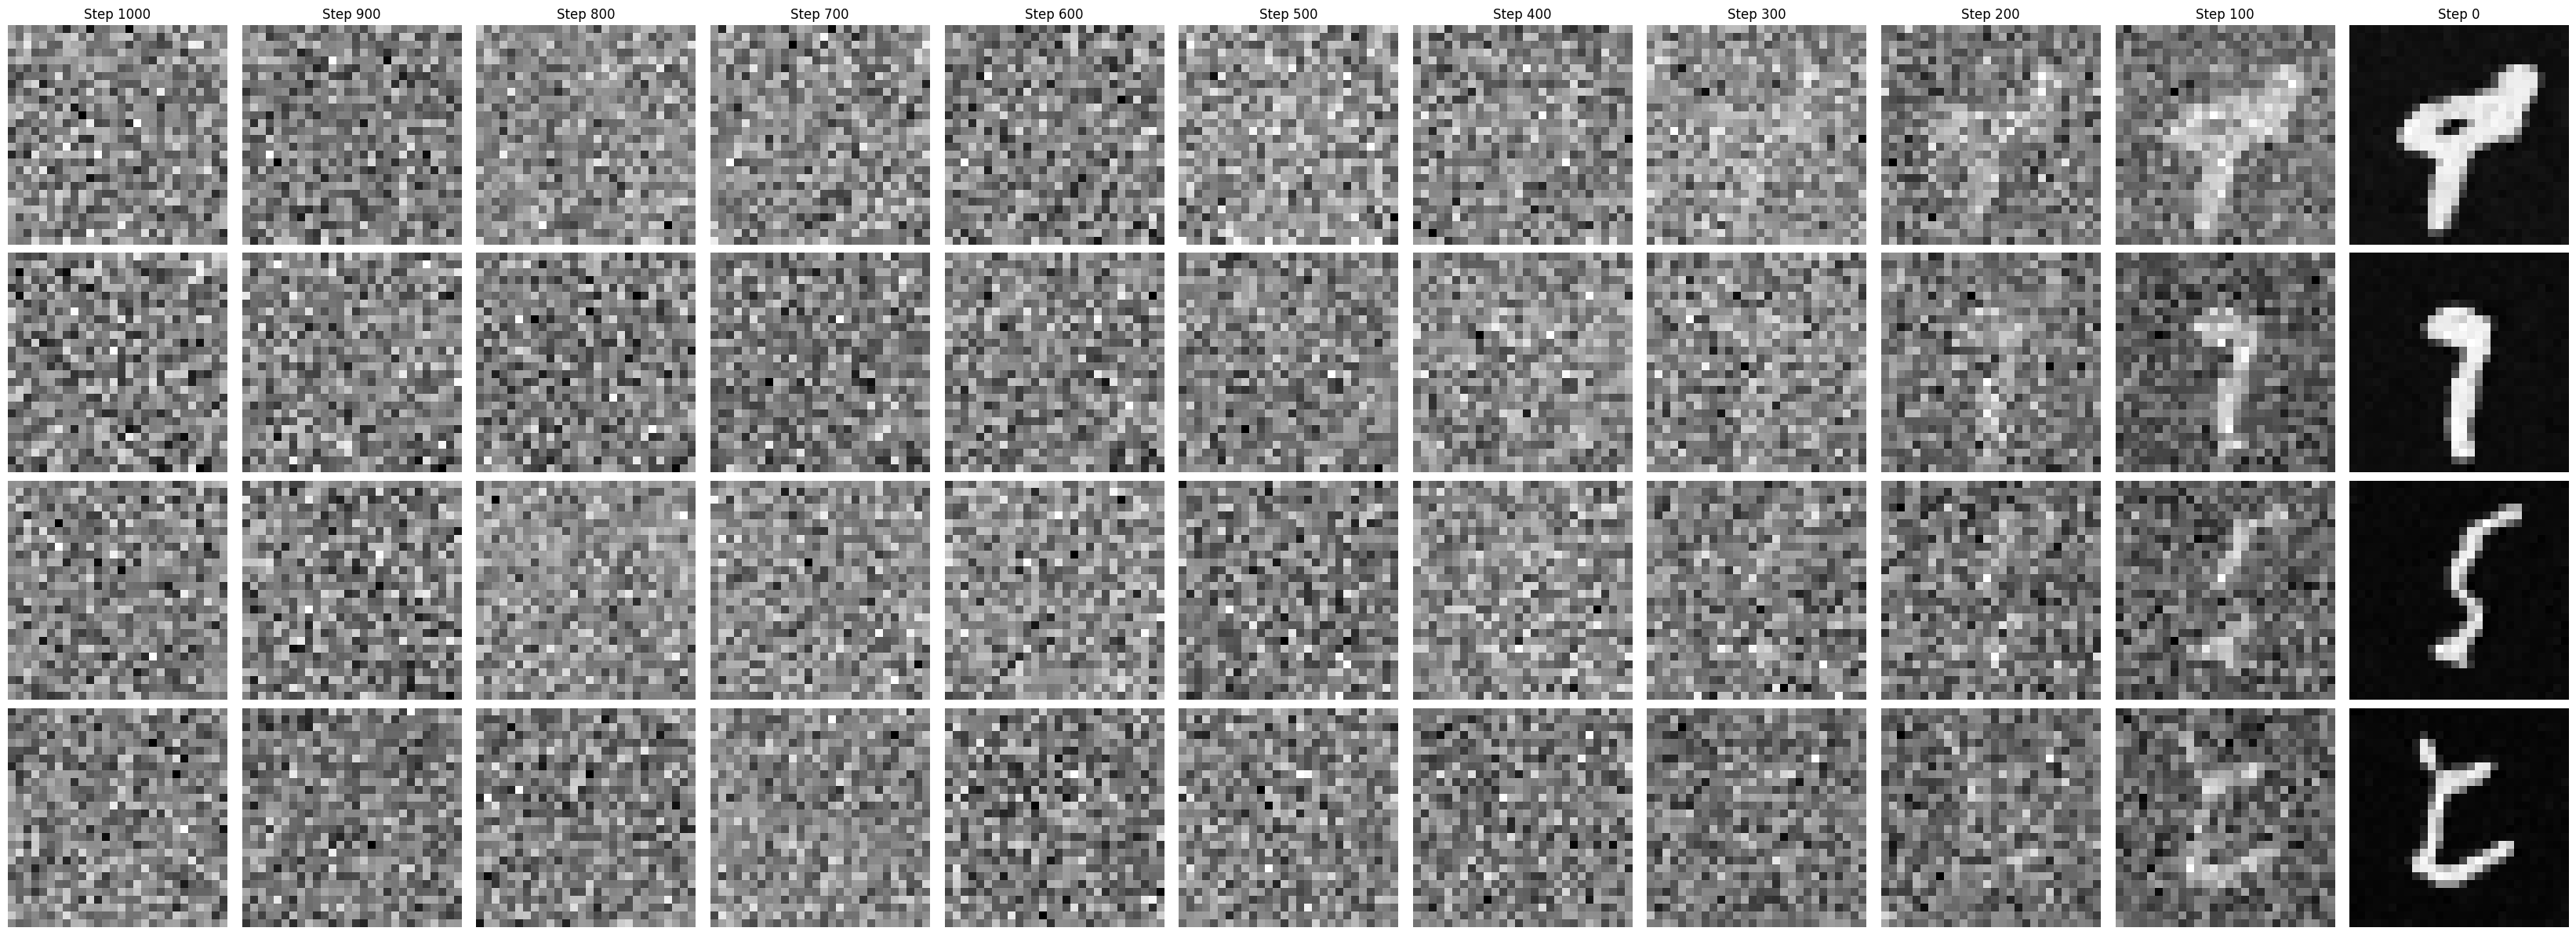

100%|██████████| 938/938 [01:08<00:00, 13.72it/s, epoch=10, loss: =0.0128, img shape: =torch.Size([32, 1, 28, 28]), LR=0.0005] 


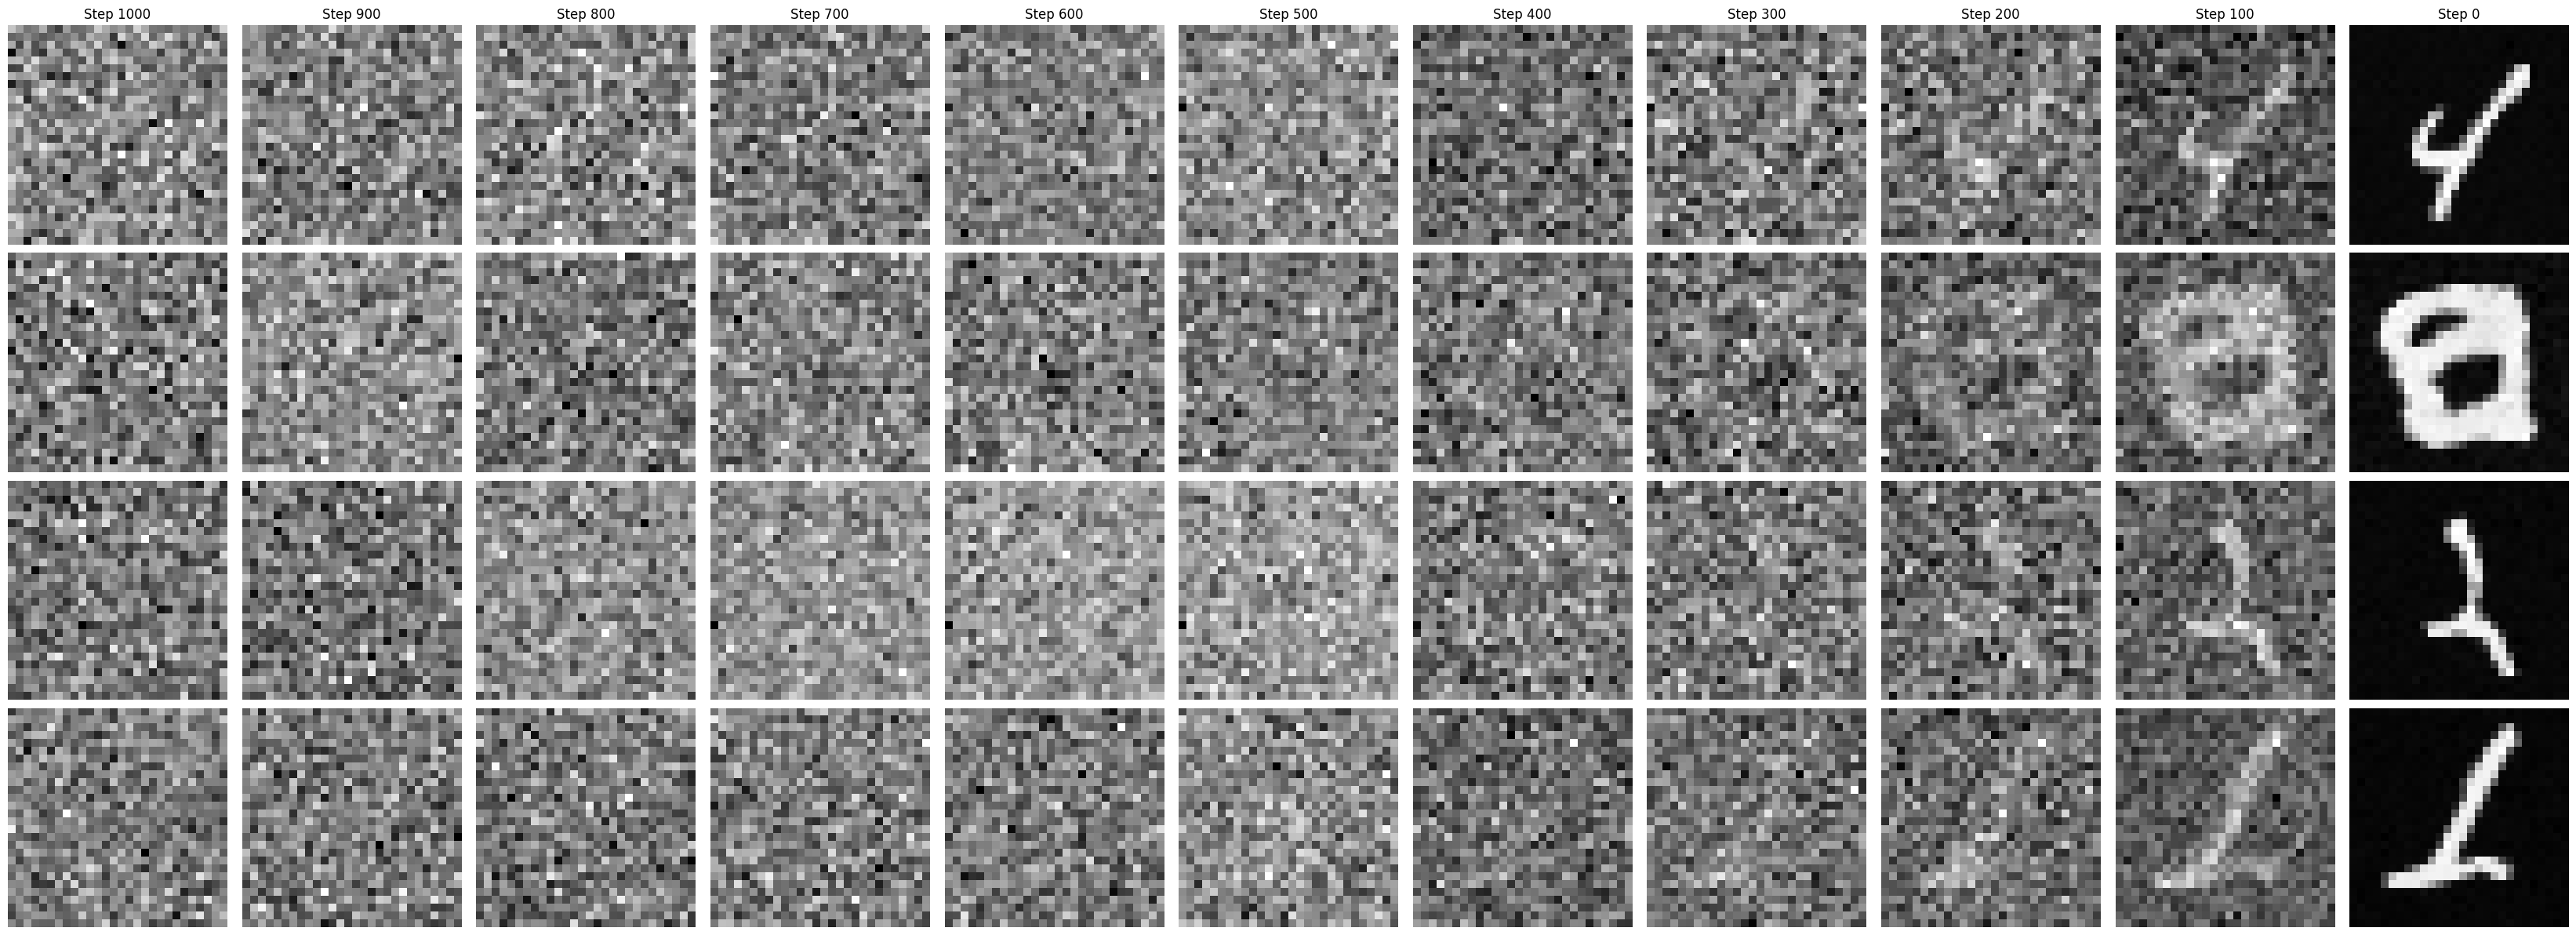

100%|██████████| 938/938 [01:08<00:00, 13.76it/s, epoch=20, loss: =0.012, img shape: =torch.Size([32, 1, 28, 28]), LR=0.0005]  


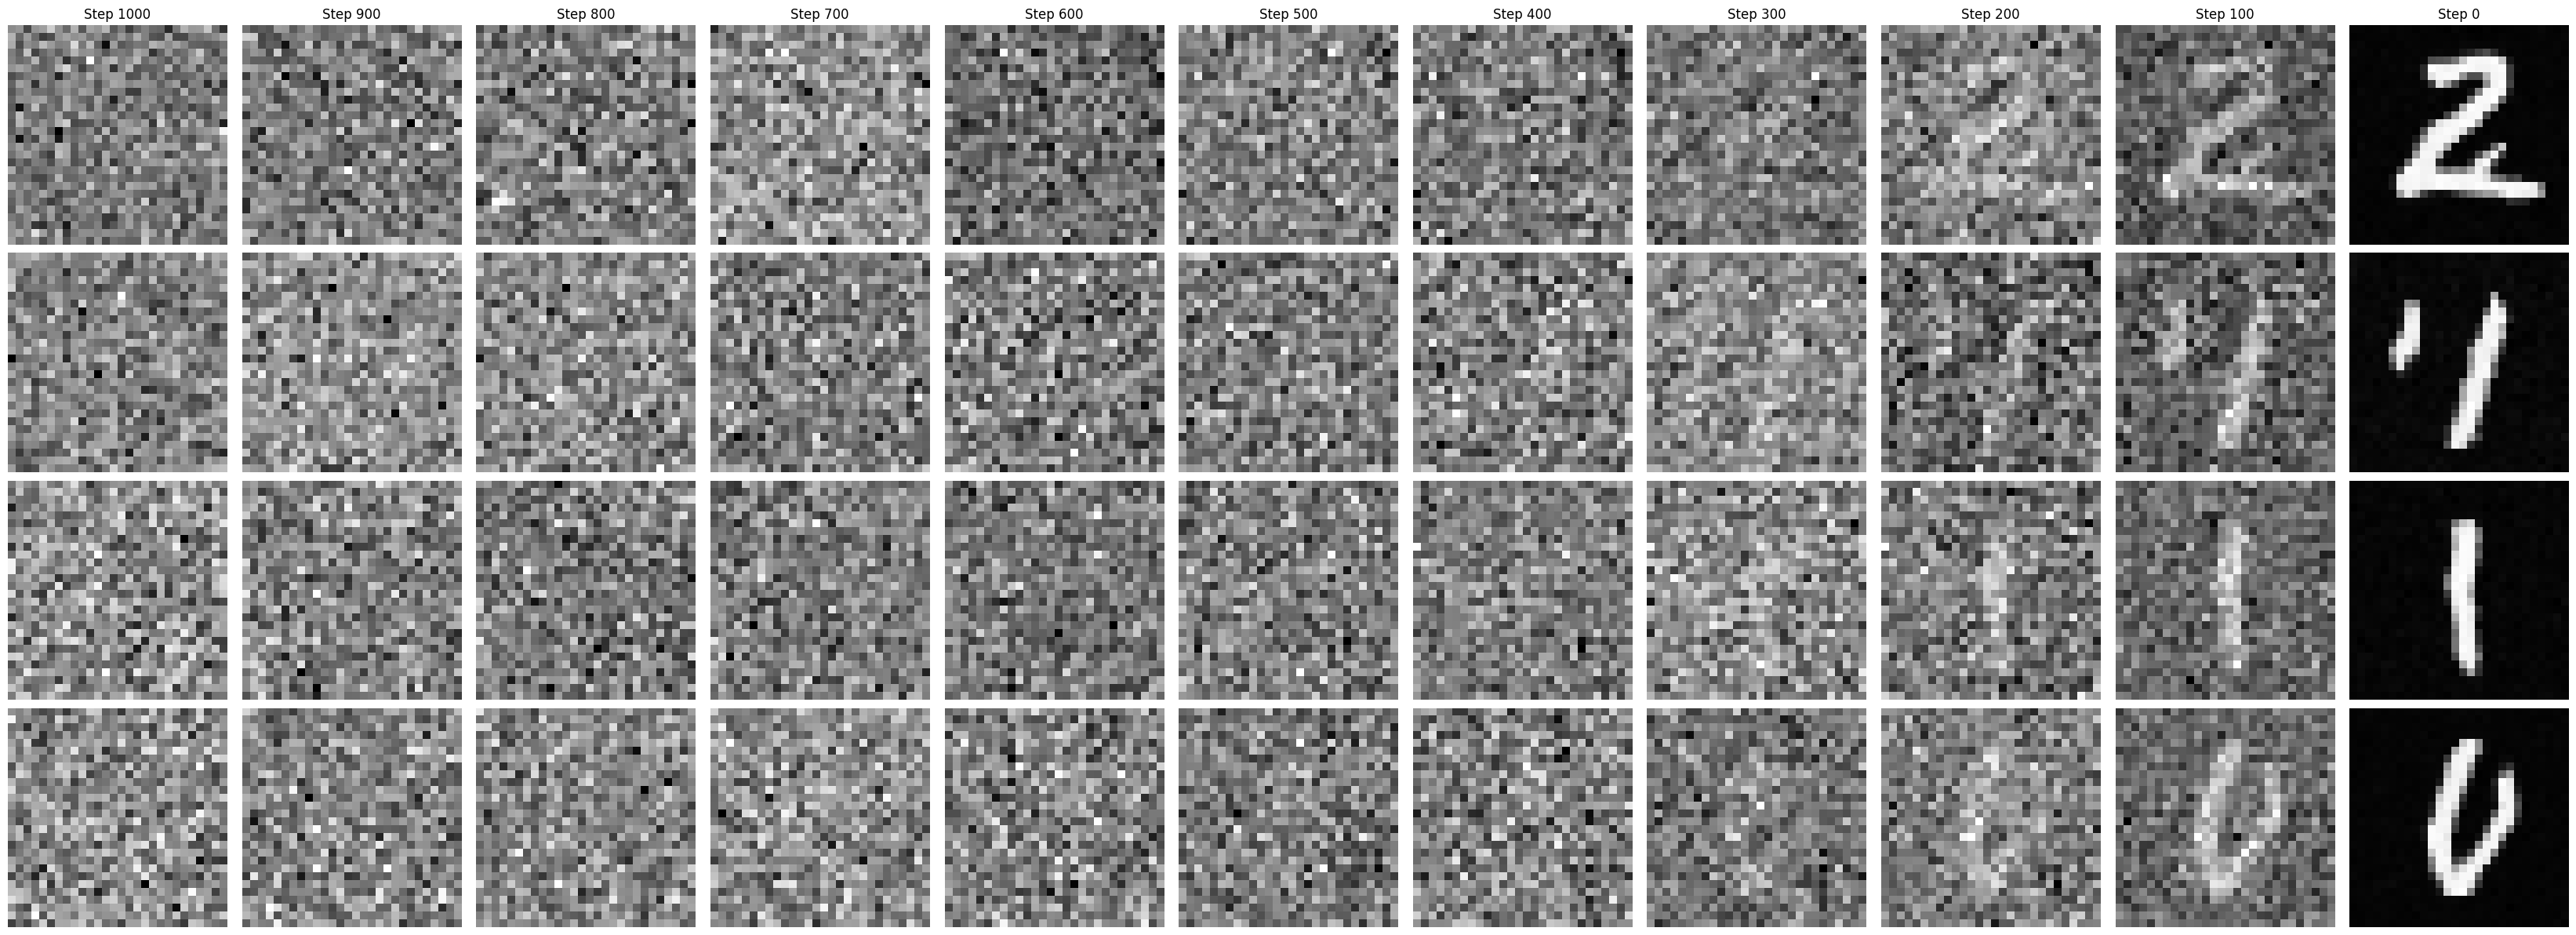

100%|██████████| 938/938 [01:08<00:00, 13.74it/s, epoch=30, loss: =0.0166, img shape: =torch.Size([32, 1, 28, 28]), LR=0.0005] 


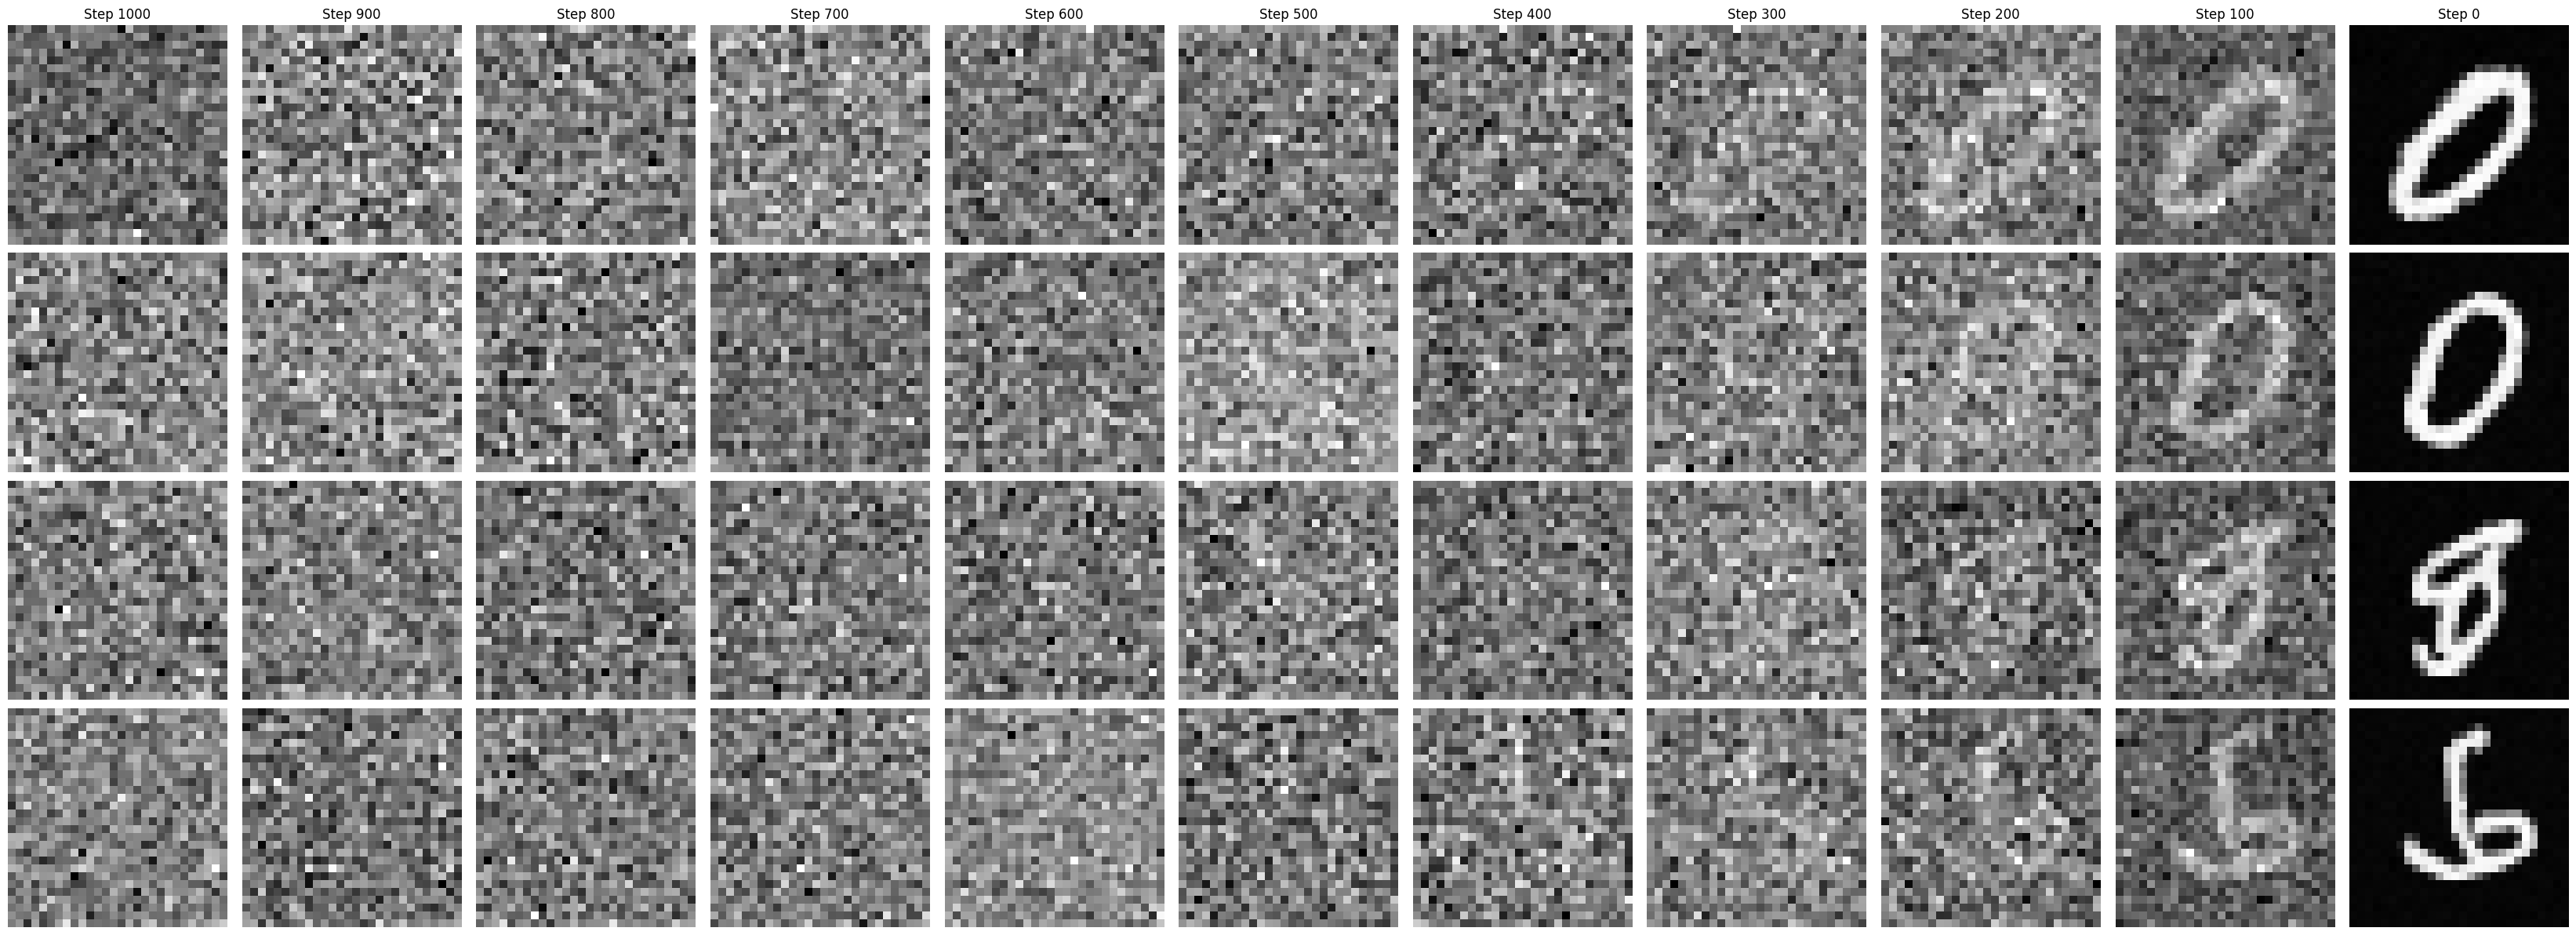

100%|██████████| 938/938 [01:08<00:00, 13.72it/s, epoch=40, loss: =0.0103, img shape: =torch.Size([32, 1, 28, 28]), LR=0.0005] 


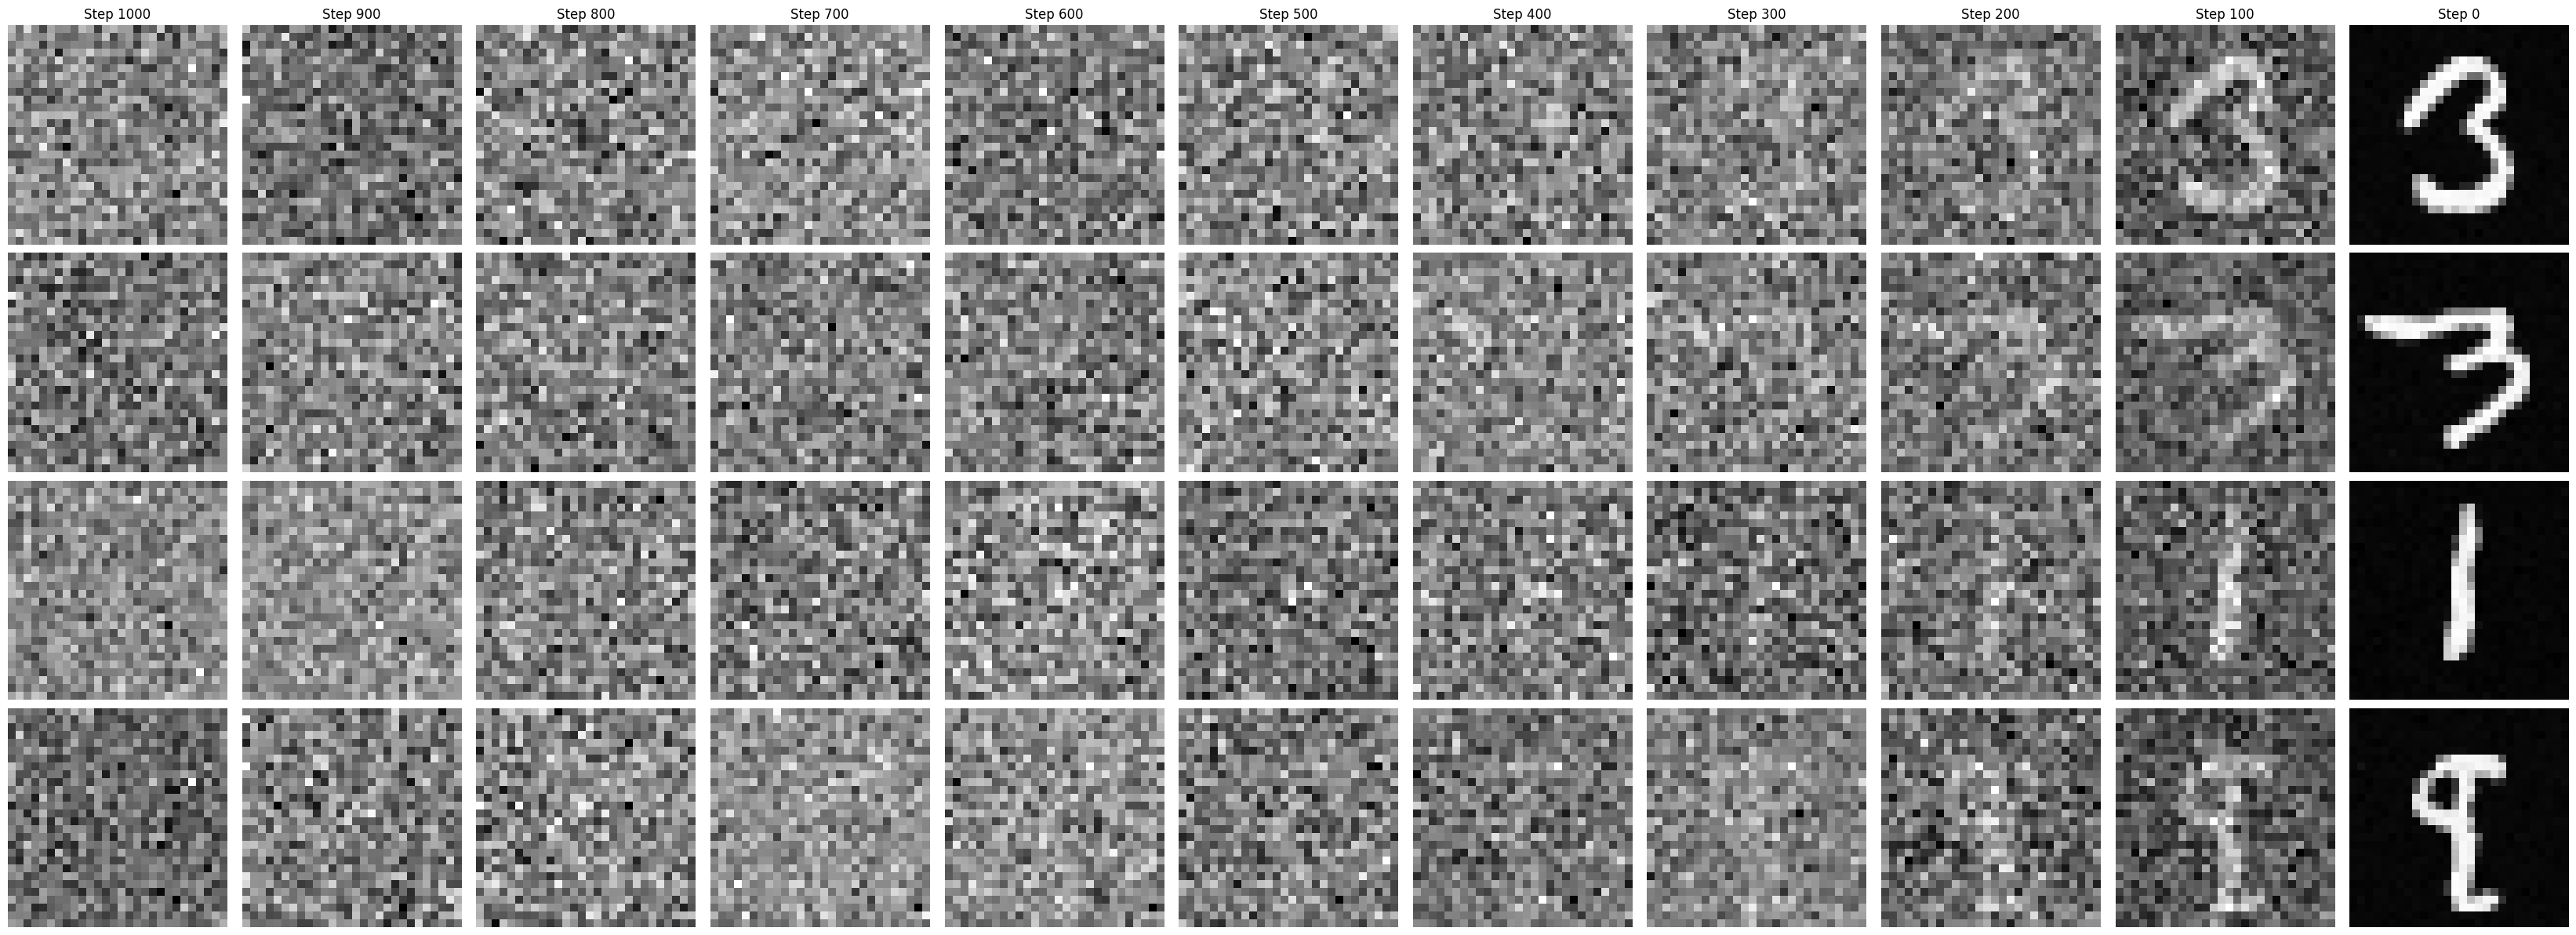

 36%|███▌      | 334/938 [00:24<00:44, 13.69it/s, epoch=45, loss: =0.0143, img shape: =torch.Size([64, 1, 28, 28]), LR=0.0005] 


KeyboardInterrupt: 

In [26]:
train(modelConfig)

In [6]:
def get_score_fn(model, ddpm_loss):
    def score(x_t, t):
        std = ddpm_loss.sqrt_1m_alpha[transform(t, ddpm_loss.T)][:, None, None, None]
        noise_pred = model(x_t, t)
        return -noise_pred / std
    return score

In [63]:
class AncestralSampling(nn.Module):
    def __init__(self, T, model, beta_0, beta_1):
        super().__init__()
        self.T = T  # Number of distinct timesteps (not counting 0).
        self.score = get_score_fn(model, DiffusionLoss(T, model, beta_0, beta_1).to(device))
        self.register_buffer('beta', torch.linspace(beta_0, beta_1, T))

    def generate_visualize(self):
        x = torch.randn(4, 1, 28, 28).to(device)
        xs = [x.cpu().detach().numpy()]
        for time in tqdm(reversed(range(self.T)), total=self.T):
            if time == 0:
                noise = 0
            else:
                noise = torch.randn_like(x).to(device)
            t = x.new_ones(x.shape[0]) * time / self.T
            beta = self.beta[transform(t, self.T)]
            beta = beta[:, None, None, None]
            score = self.score(x, t)
            x = 1 / torch.sqrt(1 - beta) * (x + beta * score) + torch.sqrt(beta) * torch.randn_like(x).to(device)
            if time % (self.T // 10) == 0:
                xs.append(x.cpu().detach().numpy())
        return xs            
        

In [54]:
modelConfig2 = {
        "state": "train",
        "epoch": 50,
        "batch_size": 64,
        "T": 1000,
        "channel": 32,
        "channel_mult": [1, 2],
        "attn": [],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 5e-4,
        "multiplier": 2.,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 28,
        "grad_clip": 1.,
        "device": "cuda:0",
        "training_load_weight": None,
        "save_weight_dir": "./CheckpointsDDPM/",
        "display_epochs": True,
        "test_load_weight": "ckpt_44_.pt",
        "sampled_dir": "",
        "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
        "sampledImgName": "SampledImagesNew.png",
        "nrow": 8,
        "show_process": True,
        "sampler_class": AncestralSampling
        }

In [60]:
def sample_score(modelConfig):
    with torch.no_grad():
        device = torch.device(modelConfig["device"])
        model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=0.)
        ckpt = torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device, weights_only=True)
        model.load_state_dict(ckpt)
        model.eval()
        sampler_class = modelConfig['sampler_class']
        sampler = sampler_class(modelConfig["T"], model, modelConfig["beta_1"], modelConfig["beta_T"]).to(device)
        # Sampled from standard normal distribution
        noisyImage = torch.randn(size=[modelConfig["batch_size"], 1, 28, 28], device=device)
        
        if modelConfig['show_process']:
            # showing diffusion process
            images = sampler.generate_visualize()
            display_diffusion(images)
        else:
        # generating final image:
            saveNoisy = torch.clamp(noisyImage, 0, 1)
            save_image(saveNoisy, os.path.join(
                modelConfig["sampled_dir"], modelConfig["sampledNoisyImgName"]), nrow=modelConfig["nrow"])
            sampledImgs = sampler(noisyImage)
            save_image(sampledImgs, os.path.join(
                modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])

100%|██████████| 1000/1000 [00:09<00:00, 109.65it/s]


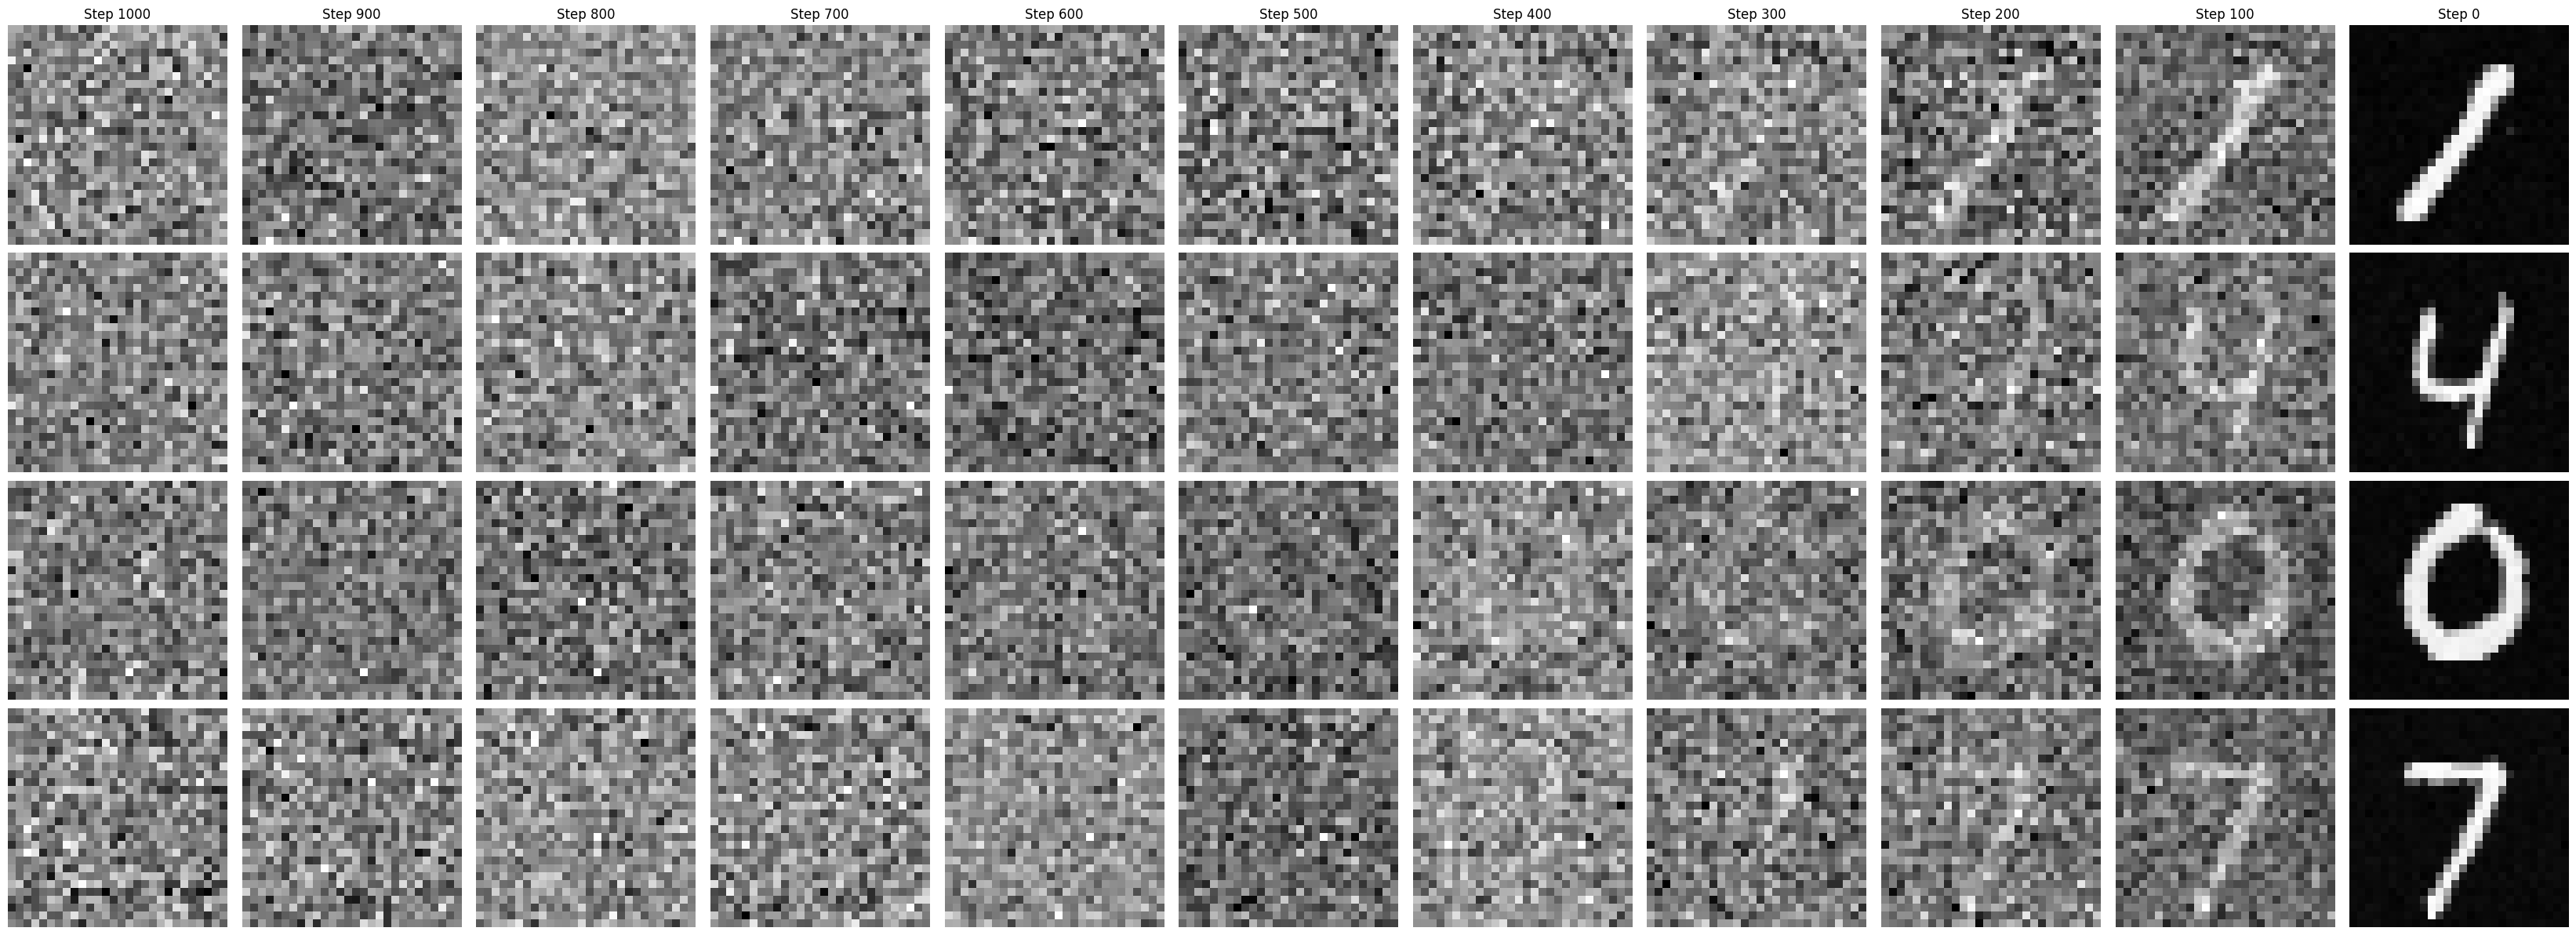

In [64]:
sample_score(modelConfig2)

We can see that the above model works, essentially using diffusion with a slight twist ($t \in [0,1]$ instead of $t \in [0, T]$, different time embedding, using the SDE ancestral sampling method)

## True SDE Implementation (Not relying on discretization and alphas at all).

In [7]:
class VPSDE:
    def __init__(self, beta_0, beta_1, T_discrete, device):
        self.beta_0 = beta_0
        self.beta_1 = beta_1
        self.T_discrete = T_discrete
        self.device = device

        ### PARAMETERS FOR DISCRETE STEPS OF DIFFUSION ###
        self.betas = torch.linspace(beta_0, beta_1, T_discrete).to(device)
        a = 1 - self.betas
        alphas = torch.cumprod(a, 0)
        self.sqrt_alpha = alphas.sqrt()
        self.sqrt_1m_alpha = (1 - alphas).sqrt()

    def beta(self, t):
        # assert all(t>=0) and all(t<=1)
        return self.beta_0 * self.T_discrete + (self.beta_1 - self.beta_0) * t * self.T_discrete

    def drift_diffusion(self, x, t):
        beta = self.beta(t)[:, None, None, None]
        return -0.5 * beta * x, torch.sqrt(beta)
        
    def dist(self, x_0, t):
        """
        Return the distribution of x(t) given x(0). (Normal with mean and std)
        """
        integral = (self.beta(0) * t + 0.5 * (self.beta(1) - self.beta(0)) * t ** 2)[:, None, None, None]
        mean = x_0 * torch.exp(-0.5*integral)
        var = 1 - torch.exp(-integral)
        return mean, torch.sqrt(var)

    def reverse_drift_diffusion(self, score_fn, x, t):
        drift, diffusion = self.drift_diffusion(x, t)
        return drift - diffusion ** 2 * score_fn(x, t), diffusion
        

In [8]:
class SDELoss(nn.Module):
    def __init__(self, sde, model):
        super().__init__()
        self.sde = sde
        self.model = model

    def forward(self, x):
        """
        x is a training batch of images (B, C, H, W)
        """
        t = torch.rand((x.shape[0],), device=device)
        noise = torch.randn_like(x, device=device)
        mean, std = self.sde.dist(x, t)
        x_t = mean + std * noise
        noise_pred = self.model(x_t, t)
        return F.mse_loss(noise_pred, noise)

In [9]:
def get_score_fn_continuous(model, sde):
    def score(x_t, t):
        std = sde.dist(x_t, t)[1]
        noise_pred = model(x_t, t)
        if all(t==0):
            return -noise_pred / sde.sqrt_1m_alpha[t.to(torch.int)][:, None, None, None]
        return -noise_pred / std
    return score

In [10]:
class AncestralSamplingContinuous(nn.Module):
    def __init__(self, model, sde):
        super().__init__()
        self.T = sde.T_discrete  # Number of distinct timesteps (not counting 0).
        self.sde = sde
        self.score = get_score_fn_continuous(model, sde)
        self.register_buffer('beta', torch.linspace(sde.beta_0, sde.beta_1, self.T))

    def forward(self, x):
        for time in tqdm(reversed(range(self.T)), total=self.T):
            if time == 0:
                noise = 0
            else:
                noise = torch.randn_like(x).to(device)
            t = x.new_ones(x.shape[0]) * time / self.T
            beta = self.beta[transform(t, self.T)]
            beta = beta[:, None, None, None]
            score = self.score(x, t)
            x = 1 / torch.sqrt(1 - beta) * (x + beta * score) + torch.sqrt(beta) * torch.randn_like(x).to(device)
        return x
        # final denoising step
        
        
        return xs            
        

    def generate_visualize(self):
        x = torch.randn(4, 1, 28, 28).to(device)
        xs = [x.cpu().detach().numpy()]
        for time in tqdm(reversed(range(self.T)), total=self.T):
            if time == 0:
                noise = 0
            else:
                noise = torch.randn_like(x).to(device)
            t = x.new_ones(x.shape[0]) * time / self.T
            beta = self.beta[transform(t, self.T)]
            beta = beta[:, None, None, None]
            score = self.score(x, t)
            x = 1 / torch.sqrt(1 - beta) * (x + beta * score) + torch.sqrt(beta) * torch.randn_like(x).to(device)
            if time % (self.T // 10) == 0:
                xs.append(x.cpu().detach().numpy())
        # final denoising step
        
        
        return xs            
        

In [19]:
def train_sde(modelConfig: Dict):
    device = torch.device(modelConfig["device"])
    # dataset
    # Define the transform
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Load MNIST dataset
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # model setup
    model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    if modelConfig["training_load_weight"] is not None:
        model.load_state_dict(torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["training_load_weight"]), map_location=device))
    sde = VPSDE(modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], device)
    
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=modelConfig["lr"], weight_decay=1e-4)
    trainer = SDELoss(sde, model).to(device)
    sampler = AncestralSamplingContinuous(model, sde).to(device)
    
    if not os.path.exists(modelConfig["save_weight_dir"]):
        os.makedirs(modelConfig["save_weight_dir"])

    # start training
    for e in range(modelConfig["epoch"]):
        with tqdm(train_loader, dynamic_ncols=True) as tqdmDataLoader:
            for images, labels in tqdmDataLoader:
                # train
                optimizer.zero_grad()
                x_0 = images.to(device)
                loss = trainer(x_0)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), modelConfig["grad_clip"])
                optimizer.step()
                tqdmDataLoader.set_postfix(ordered_dict={
                    "epoch": e,
                    "loss: ": loss.item(),
                })
        if e % 10 == 0:
            if modelConfig["display_epochs"]:
                with torch.no_grad():
                    images = sampler.generate_visualize()
                    display_diffusion(images, modelConfig["T"], title=f'{e}')
        torch.save(model.state_dict(), os.path.join(modelConfig["save_weight_dir"], 'ckpt_' + str(e) + "_.pt"))

In [11]:
modelConfig3 = {
        "state": "train",
        "epoch": 40,
        "batch_size": 64,
        "T": 1000,
        "channel": 32,
        "channel_mult": [1, 2],
        "attn": [],
        "num_res_blocks": 2,
        "dropout": 0.15,
        "lr": 5e-4,
        "multiplier": 2.,
        "beta_1": 1e-4,
        "beta_T": 0.02,
        "img_size": 28,
        "grad_clip": 1.,
        "device": "cuda:0",
        "training_load_weight": None,
        "save_weight_dir": "./CheckpointsSDE/",
        "test_load_weight": "ckpt_39_.pt",
        "sampled_dir": "",
        "sampledNoisyImgName": "NoisyNoGuidenceImgs.png",
        "sampledImgName": "SampledImagesNew.png",
        "nrow": 8,
        "show_process": True,
        "display_epochs": True,
        }


100%|██████████| 1000/1000 [00:08<00:00, 114.51it/s]


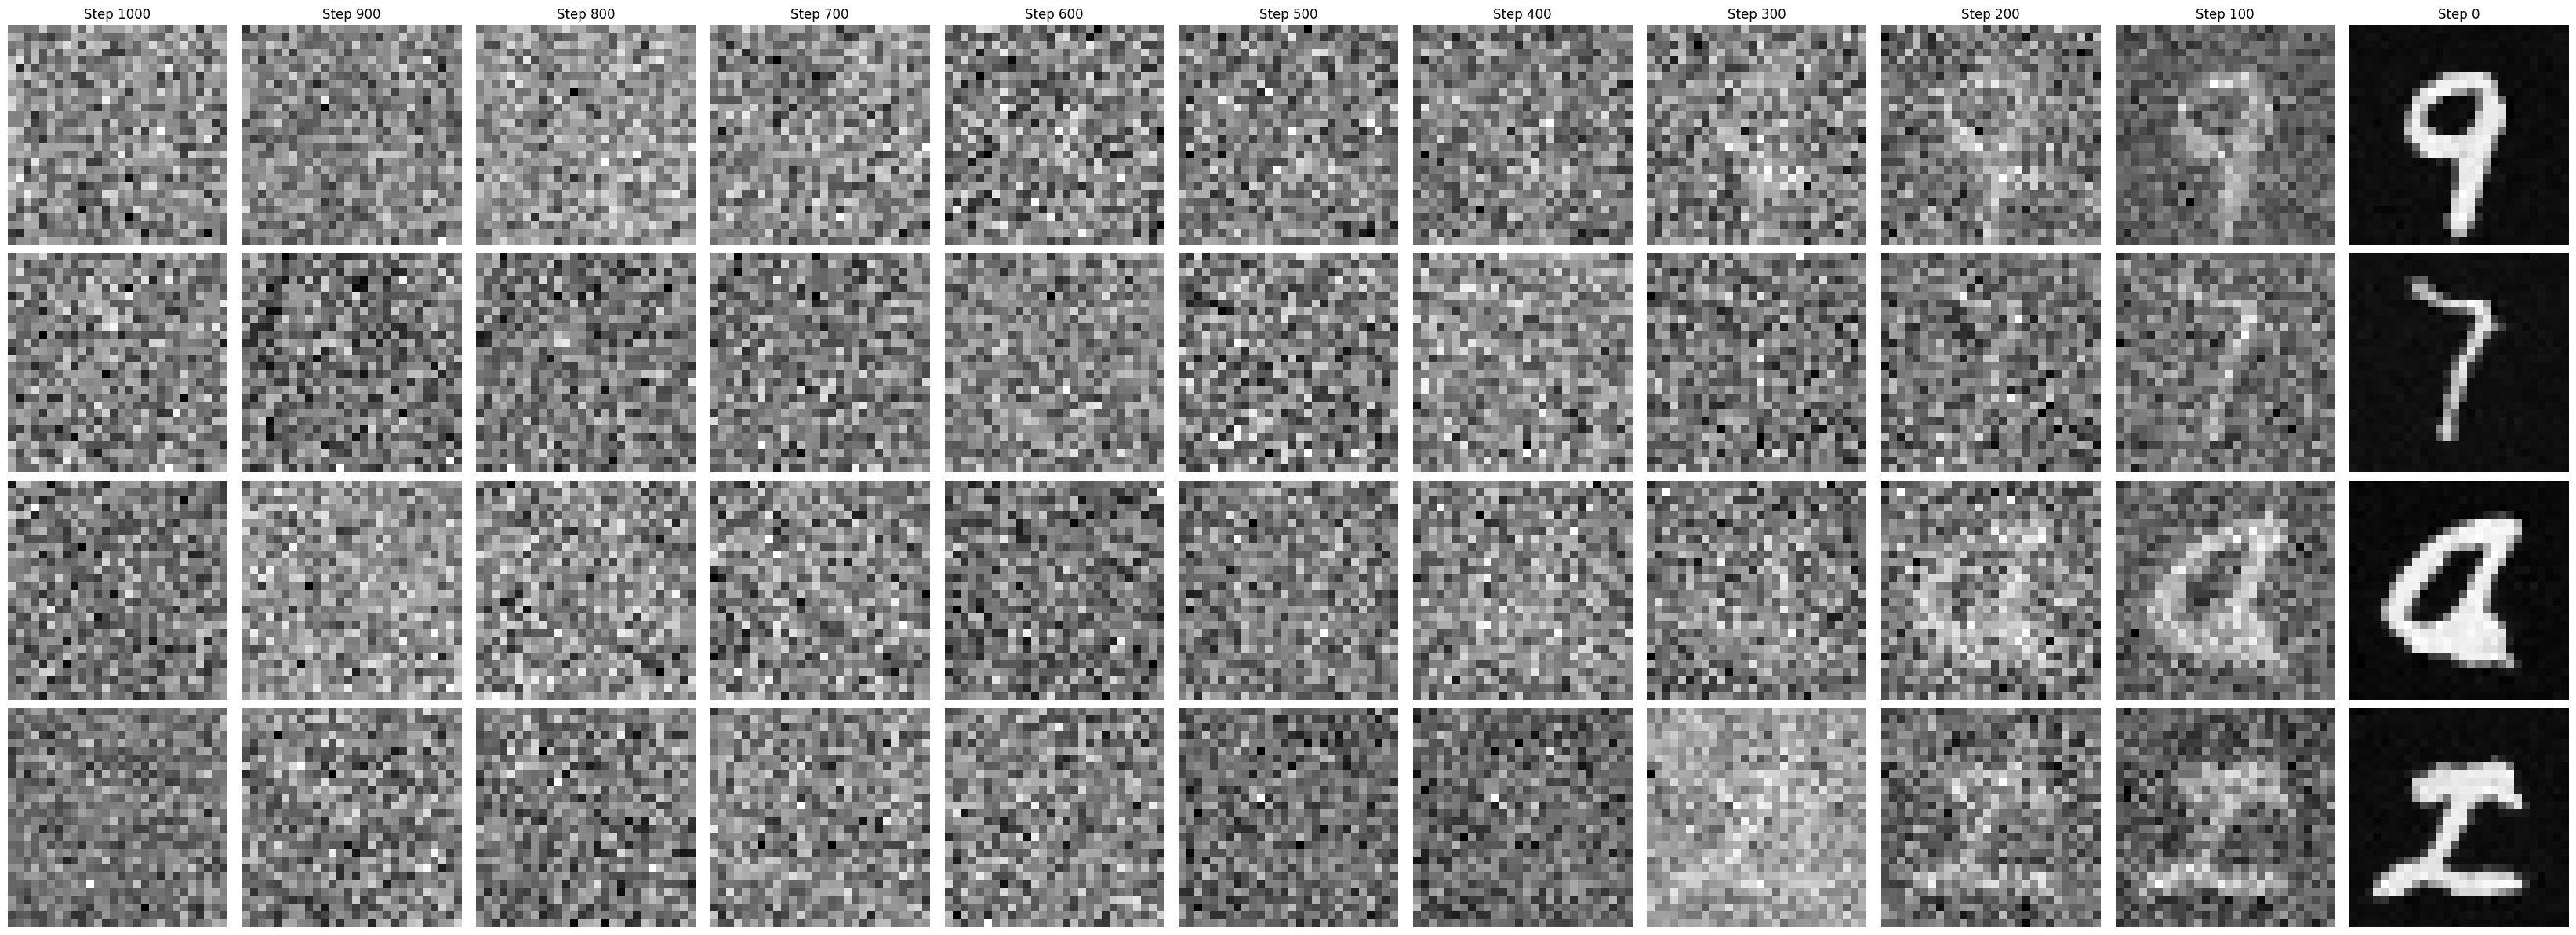

100%|██████████| 1000/1000 [00:08<00:00, 113.15it/s]


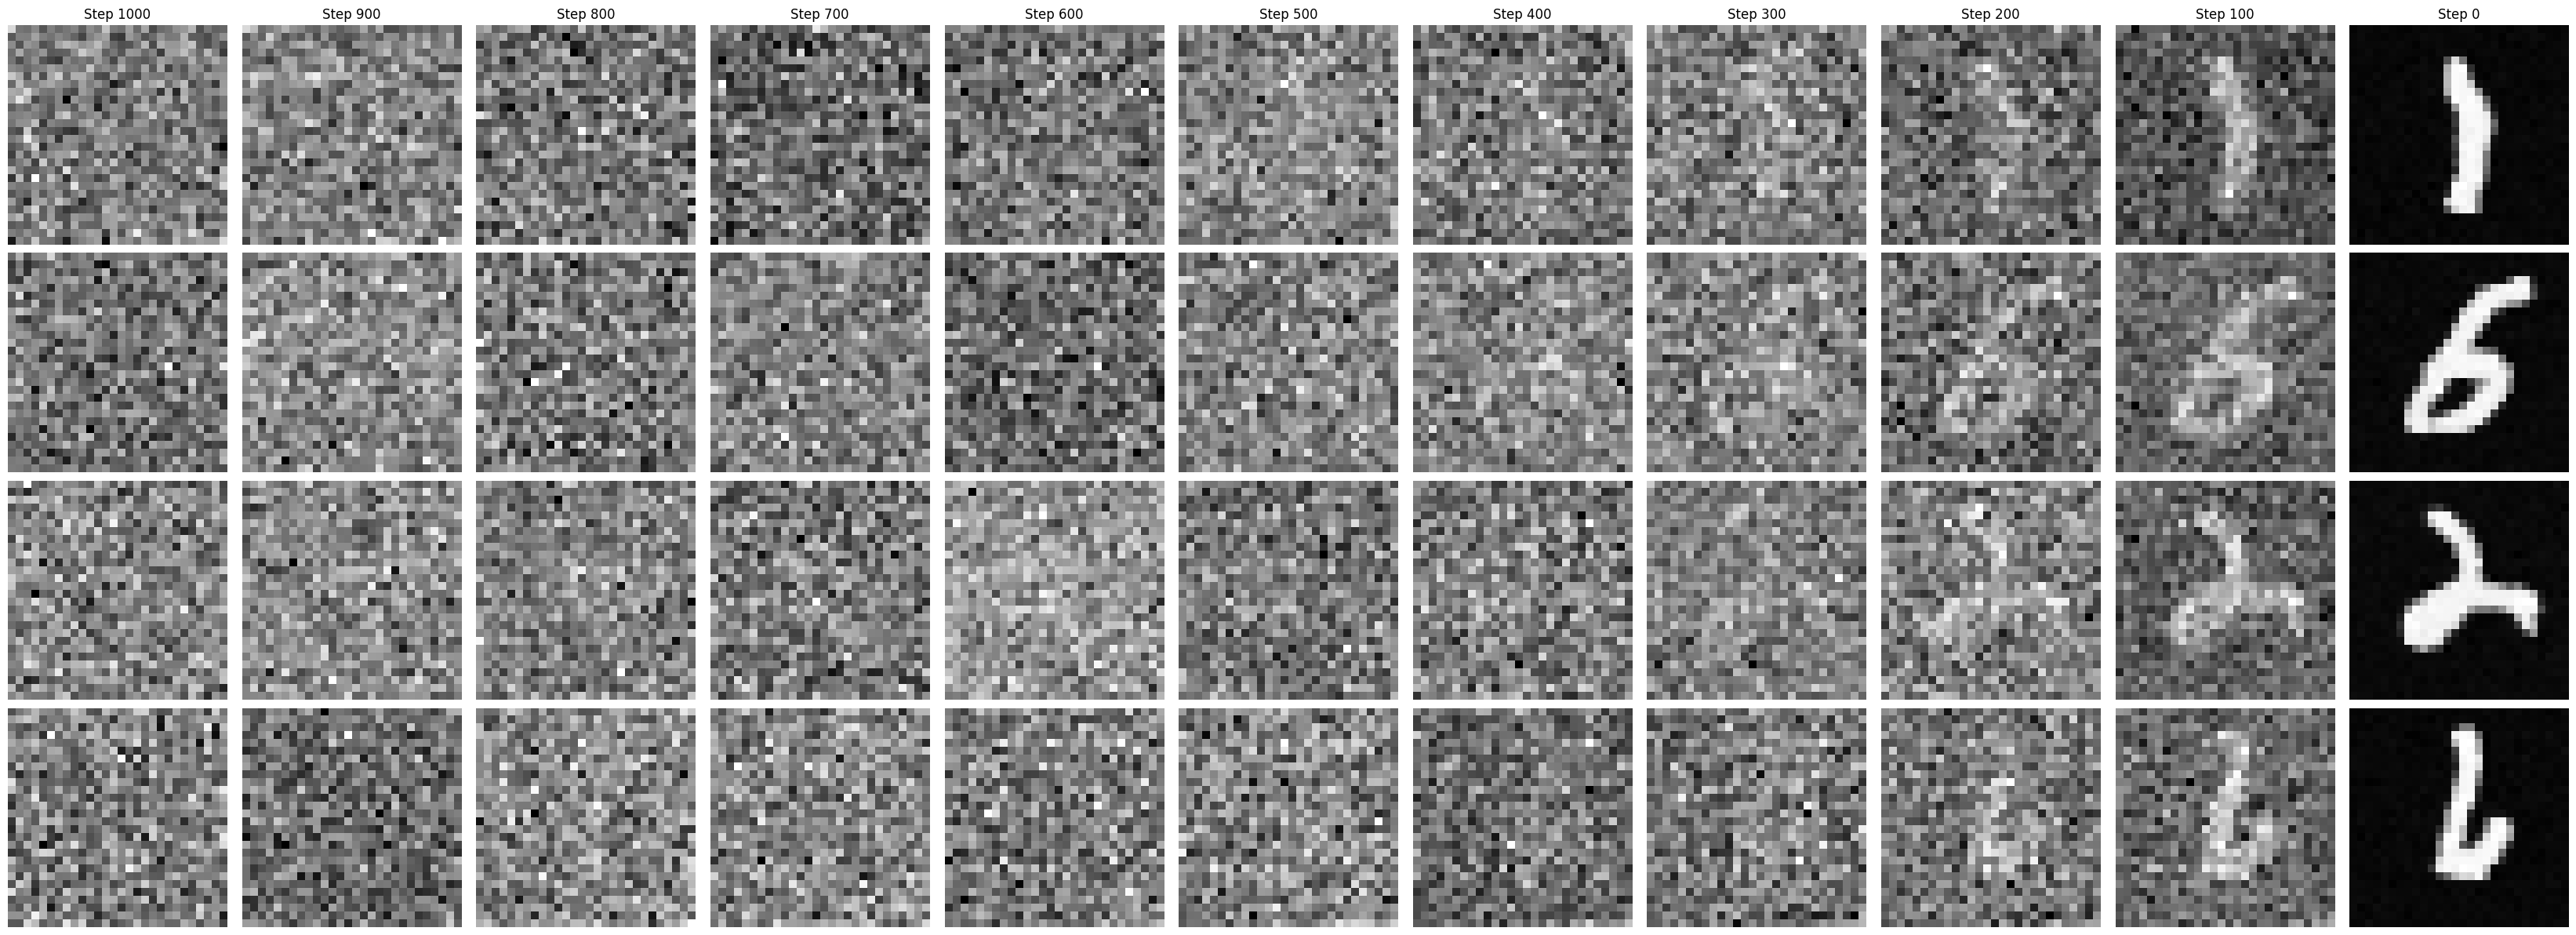

100%|██████████| 1000/1000 [00:08<00:00, 112.33it/s]


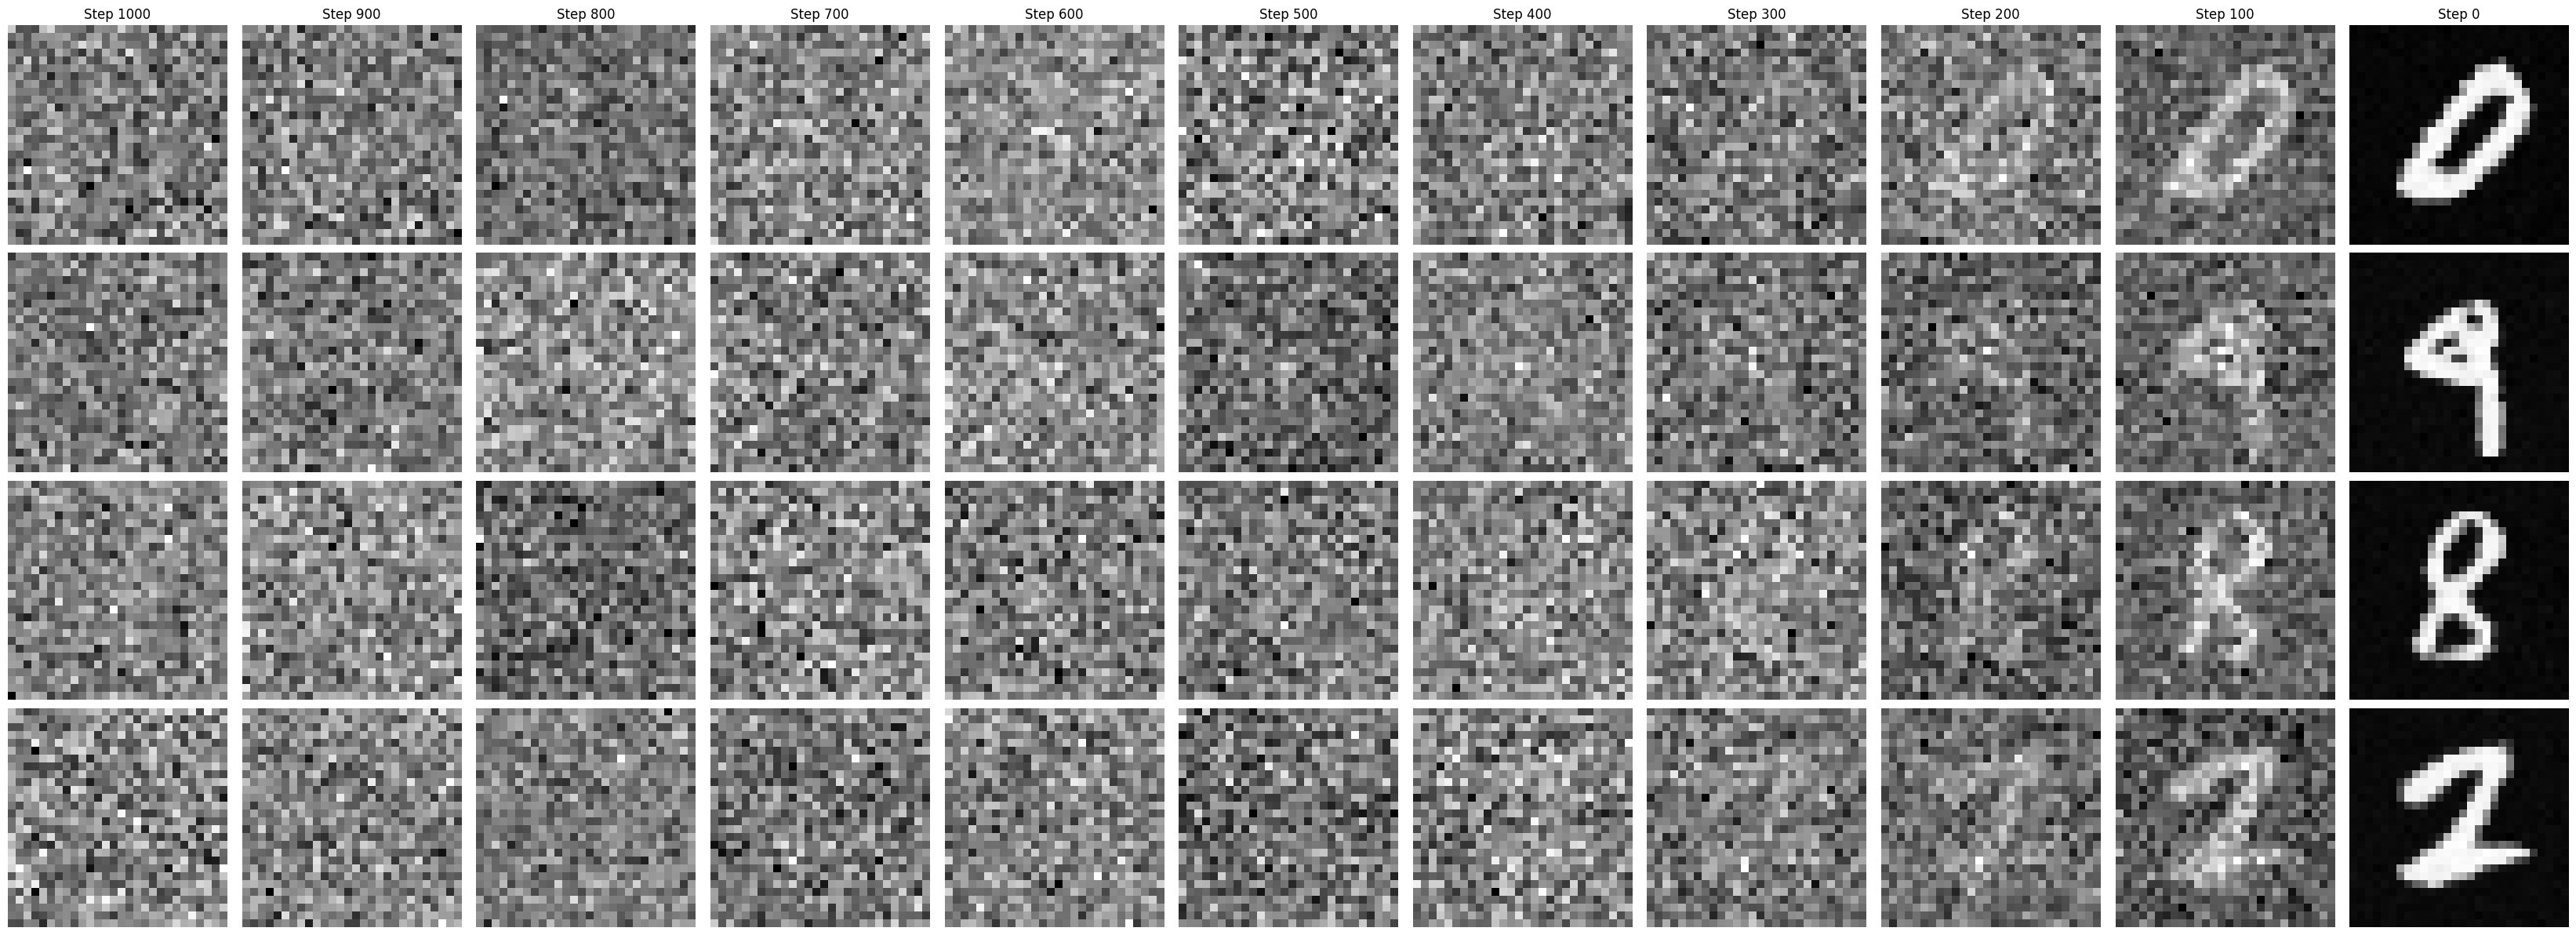

100%|██████████| 1000/1000 [00:08<00:00, 111.81it/s]


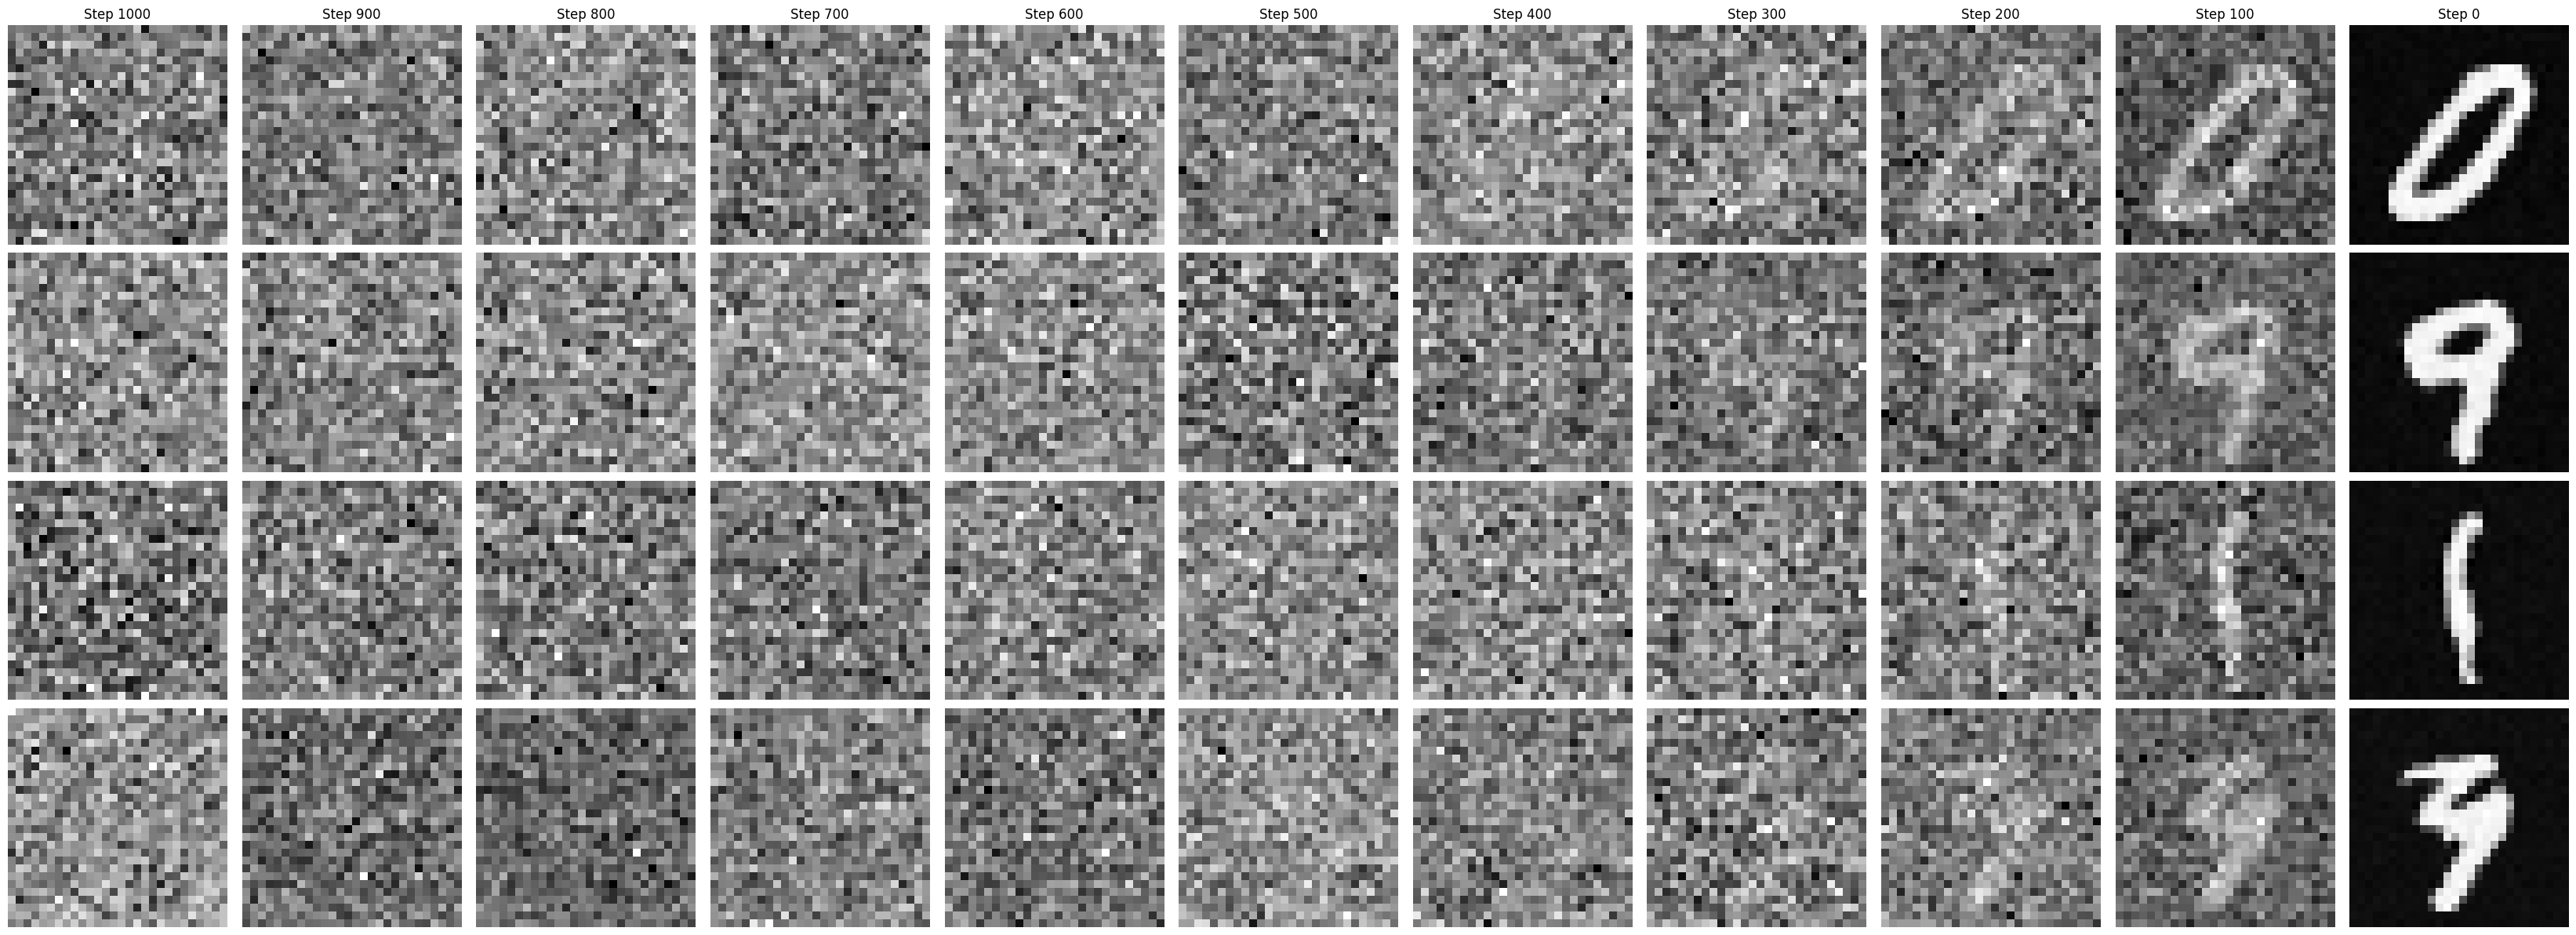

100%|██████████| 938/938 [01:04<00:00, 14.49it/s, epoch=39, loss: =0.0125] 


In [29]:
train_sde(modelConfig3)

In [12]:
def sample_images(modelConfig):
    device = torch.device(modelConfig["device"])

    # model setup
    model = UNet(T=modelConfig["T"], ch=modelConfig["channel"], ch_mult=modelConfig["channel_mult"], attn=modelConfig["attn"],
                     num_res_blocks=modelConfig["num_res_blocks"], dropout=modelConfig["dropout"]).to(device)
    ckpt = torch.load(os.path.join(
            modelConfig["save_weight_dir"], modelConfig["test_load_weight"]), map_location=device, weights_only=True)
    model.load_state_dict(ckpt)
    model.eval()
    
    sde = VPSDE(modelConfig["beta_1"], modelConfig["beta_T"], modelConfig["T"], device)
    sampler = AncestralSamplingContinuous(model, sde).to(device)
    
    if not os.path.exists(modelConfig["save_weight_dir"]):
        os.makedirs(modelConfig["save_weight_dir"])

    noisyImage = torch.randn(size=[modelConfig["batch_size"], 1, 28, 28], device=device)

    with torch.no_grad():
        images = sampler.generate_visualize()
        sampledImgs = sampler(noisyImage)
    display_diffusion(images, modelConfig["T"], title='final')

    
    save_image(sampledImgs, os.path.join(
        modelConfig["sampled_dir"],  modelConfig["sampledImgName"]), nrow=modelConfig["nrow"])

100%|██████████| 1000/1000 [00:20<00:00, 49.41it/s]


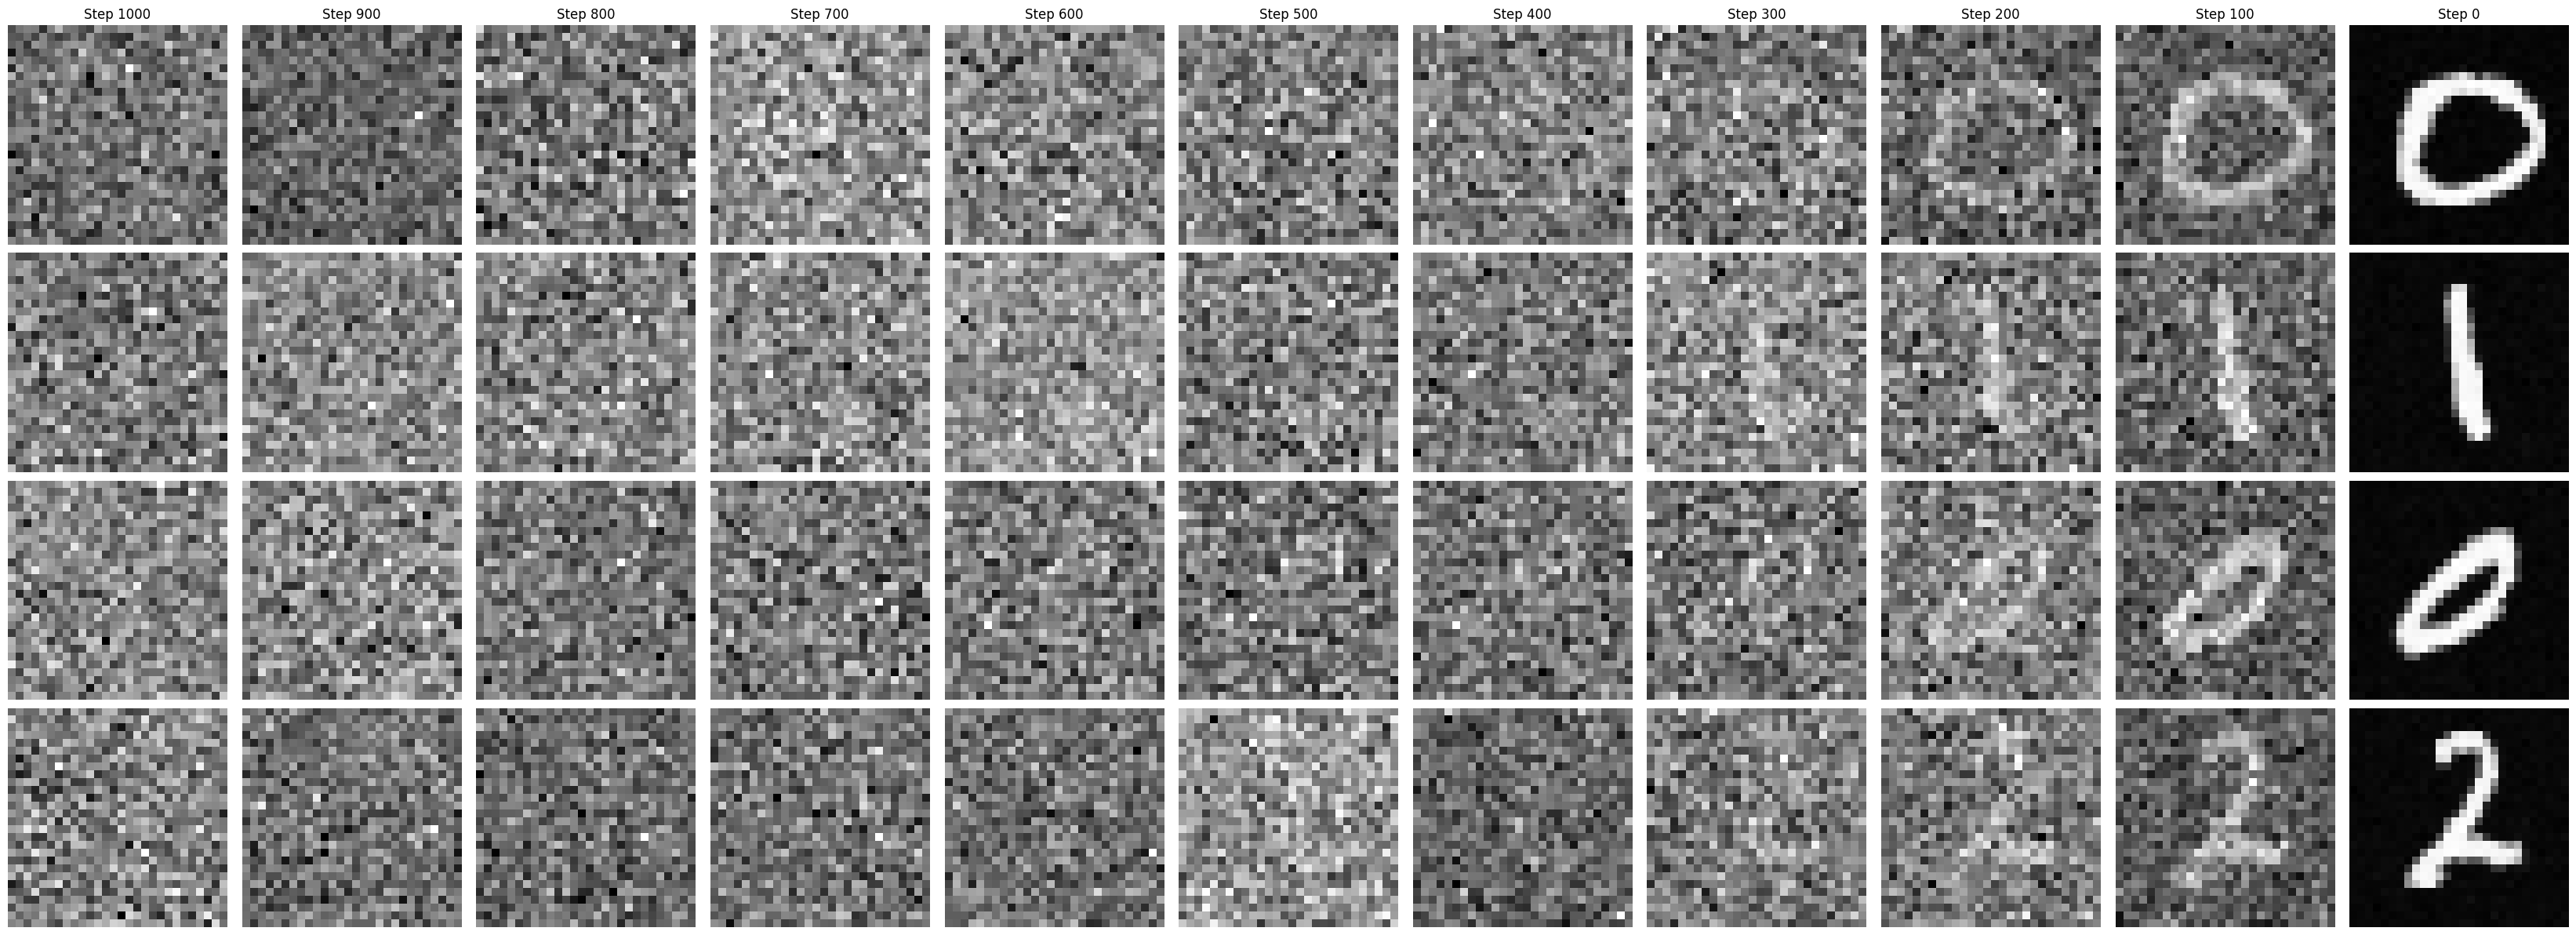

In [14]:
sample_images(modelConfig3)